In [1]:
import sqlite3
import datetime
import pandas as pd

# 连接到 SQLite 数据库
conn = sqlite3.connect('/kaggle/input/bitcoin-data/bitcoin_data.db')
cursor = conn.cursor()

# 执行 SQL 查询
query_1m = f"SELECT * FROM bitcoin_data_1m"
query_3m = f"SELECT * FROM bitcoin_data_3m"
query_5m = f"SELECT * FROM bitcoin_data_5m"
query_15m = f"SELECT * FROM bitcoin_data_15m"

# 获取查询结果-df格式
data_1m = pd.read_sql(query_1m, conn)
# data_3m = pd.read_sql(query_3m, conn)
# data_5m = pd.read_sql(query_5m, conn)
# data_15m = pd.read_sql(query_15m, conn)

# 关闭数据库连接
conn.close()

In [2]:
def process_timestamp(df, timestamp_col='Open_time'):
    """
    处理时间戳列：
    1. 将时间戳列转换为字符串，检查长度。
    2. 若长度为16（毫秒级时间戳），则转为秒级（除以1000）。
    3. 最终确保时间戳为整数类型。
    """
    # 转换为字符串检查长度
    df[timestamp_col] = df[timestamp_col].astype(str)
    
    # 处理时间戳（毫秒转秒）
    df[timestamp_col] = df[timestamp_col].apply(
        lambda x: int(x) // 1000 if len(x) == 16 else int(x)
    )
    
    # 确保为整数类型
    df[timestamp_col] = df[timestamp_col].astype(int)
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='ms')
    return df

data_1m = process_timestamp(data_1m)
# data_3m = process_timestamp(data_3m)
# data_5m = process_timestamp(data_5m)
# data_15m = process_timestamp(data_15m)

In [3]:
import numpy as np
df_train = data_1m[(data_1m['Open_time'] >= '2024-01-01 00:00:00') & (data_1m['Open_time'] < '2025-01-01 00:00:00')]
df_test = data_1m[(data_1m['Open_time'] >= '2025-01-01 00:00:00') & (data_1m['Open_time'] < '2025-04-01 00:00:00')]

In [4]:
# 确保数据按时间排序
df_train = df_train.sort_values('Open_time')
df_test = df_test.sort_values('Open_time')

# 提取相关特征
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_volume', 
            'Number_of_trades', 'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume']

# 如果时间不是索引，设置索引为时间
df_train.set_index('Open_time', inplace=True)
df_test.set_index('Open_time', inplace=True)


In [ ]:
from tqdm import tqdm
import numpy as np

def create_dataset(df, features, time_steps=120, forecast_steps=15):
    X, y = [], []
    
    # 使用tqdm来显示进度条
    for i in tqdm(range(len(df) - time_steps - forecast_steps), desc="Processing Data"):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df['Close'].iloc[i+time_steps:i+time_steps+forecast_steps].values)
    
    return np.array(X), np.array(y)

# 创建训练集和测试集
X_train, y_train = create_dataset(df_train, features)
X_test, y_test = create_dataset(df_test, features)



Processing Data: 100%|██████████| 129465/129465 [06:00<00:00, 359.27it/s]


In [9]:
import pickle

# 保存数据为 Pickle 格式
with open('data.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }, f)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# 初始化归一化器
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = np.array([scaler_X.fit_transform(x) for x in X_train])
X_test_scaled = np.array([scaler_X.transform(x) for x in X_test])

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

forecast_steps = 15

# 检查数据形状
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)

# 构建LSTM模型
model = Sequential()

# LSTM层，返回序列给下一层LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))

# 第二个LSTM层
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# 输出层，预测15个时间步
model.add(Dense(units=forecast_steps))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型，并使用验证集
model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2)


X_train_scaled shape: (526905, 120, 9)
y_train_scaled shape: (7903575, 1)
Epoch 1/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1081s 82ms/step - loss: 5.4337e-04 - val_loss: 0.0016
Epoch 2/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1075s 82ms/step - loss: 4.3587e-04 - val_loss: 0.0014
Epoch 3/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1073s 81ms/step - loss: 3.8612e-04 - val_loss: 0.0013
Epoch 4/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1068s 81ms/step - loss: 2.3929e-04 - val_loss: 0.0011
Epoch 6/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1074s 82ms/step - loss: 1.8901e-04 - val_loss: 0.0013
Epoch 7/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1074s 82ms/step - loss: 1.5806e-04 - val_loss: 0.0011
Epoch 8/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1071s 81ms/step - loss: 1.3519e-04 - val_loss: 0.0013
Epoch 9/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1074s 82ms/step - loss: 1.1891e-04 - val_loss: 0.0011
Epoch 10/10
13173/13173 ━━━━━━━━━━━━━━━━━━━━ 1073s 81ms/step - loss: 1.0767e-04 - val_loss: 0.0010


In [17]:
# 预测
y_pred_scaled = loaded_model.predict(X_test_scaled)

# 反归一化
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# 评估模型
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


4046/4046 ━━━━━━━━━━━━━━━━━━━━ 111s 27ms/step
Mean Squared Error: 2474846976.091753


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


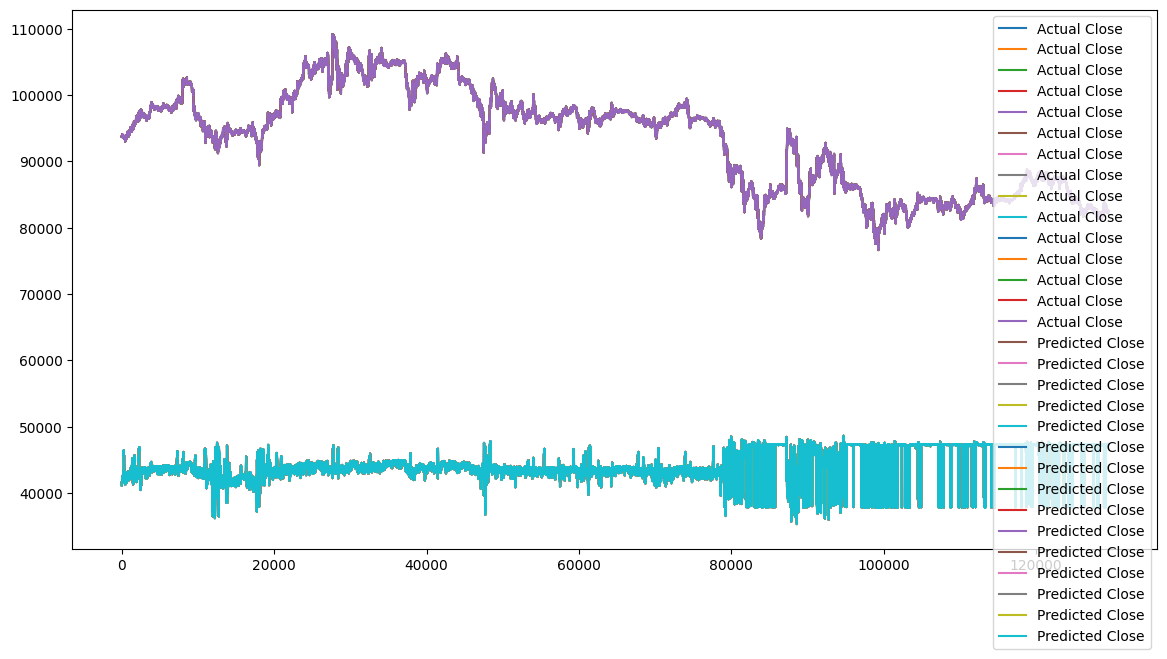

In [27]:
import matplotlib.pyplot as plt

# 绘制预测与实际值的对比
plt.figure(figsize=(14, 7))
plt.plot(y_test, label="Actual Close")
plt.plot(y_pred, label="Predicted Close")
plt.legend()
plt.show()


In [33]:
import numpy as np

# 提取第一个和第15个预测值
y_pred_signal = (y_pred[:, -1] > y_pred[:, 0]).astype(int)  # 如果第15个值大于第1个值，则买入信号为1
y_test_signal = (y_test[:, -1] > y_test[:, 0]).astype(int)  # 真实信号，同样的逻辑

# 比较预测信号和真实信号之间的差异
signal_difference = y_pred_signal - y_test_signal

# 输出预测信号和真实信号之间的差异
print("Signal Difference:", signal_difference)
print("Accuracy:", np.mean(signal_difference == 0))  # 计算预测信号与真实信号一致的比例


Signal Difference: [-1 -1 -1 ... -1 -1 -1]
Accuracy: 0.501687714826401
